# 📜Summary
**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

# >🪴Selfnotes
## 🌿Focus on Training Data first
I learned that you need to focus first on making great predictions on training data before doing any validation. If your model sucks at Training data, then it will not be any better at your test data.

## 🌿Separate models for Linear Regression
If you do Linear regression on features that are unrelated with each other, you get weird stuff. The reason is Linear Regression assumes that a feature relates with another. Grocery items does not relate with Lipstick. So there should be no reason why we should use 1 to predict the other. This is why we create models separately. You can still do the pipeline prep on all of them but the models must be trained and predicted separately.

## 🌿Be better than the Average
Always starting by visualizing the target data with the average line. This is what you need to beat. From a straight line average to a wiggly line model predictions that is closely hug the target values.

## 🌿Fast Iteration
Let your mind go fast. Remove all friction and self-doubt. Just code and explore. Allow yourself to see your code as tools for discovery and experimentation, not a rigid framework.

I still need to be more comfortable at coding in python. I am still wobbly when it comes with writing classes. I still cannot manage to add features on my pipeline at will.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

## Load
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

## Clean
transactions['date'] = pd.to_datetime(transactions['date'])
stores['cluster'] = stores['cluster'].astype(str)
store_type = dict(zip(stores['store_nbr'], stores['type']))

def cleanData(a, st):
    a['date'] = pd.to_datetime(a['date'])
    a['year'] = a['date'].dt.year
    a['weekname'] = a.date.dt.day_name()
    a['month'] = a.date.dt.month
    a['weeknum'] = a['date'].dt.isocalendar().week
    a['dayofyear'] = a['date'].dt.strftime('%j').astype(int)
    a['store_type'] = a['store_nbr'].map(st)
    return a

df = cleanData(df, store_type)

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data

# > Feature Prime
Point me in the right direction. Sales is the target and onpromotion is the feature that I need to focus on since it is the one that is highly correlated to Sales.

In [2]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

sales          1.000000
onpromotion    0.379903
id             0.083456
year           0.077355
store_nbr      0.037881
month          0.034941
dayofyear      0.034132
weeknum        0.032397
Name: sales, dtype: float64

# > Beating the Average
If I just used the average, what would it look like? The model that I will build must be better than the average. What the hell is the point if I cannot be better than the average.

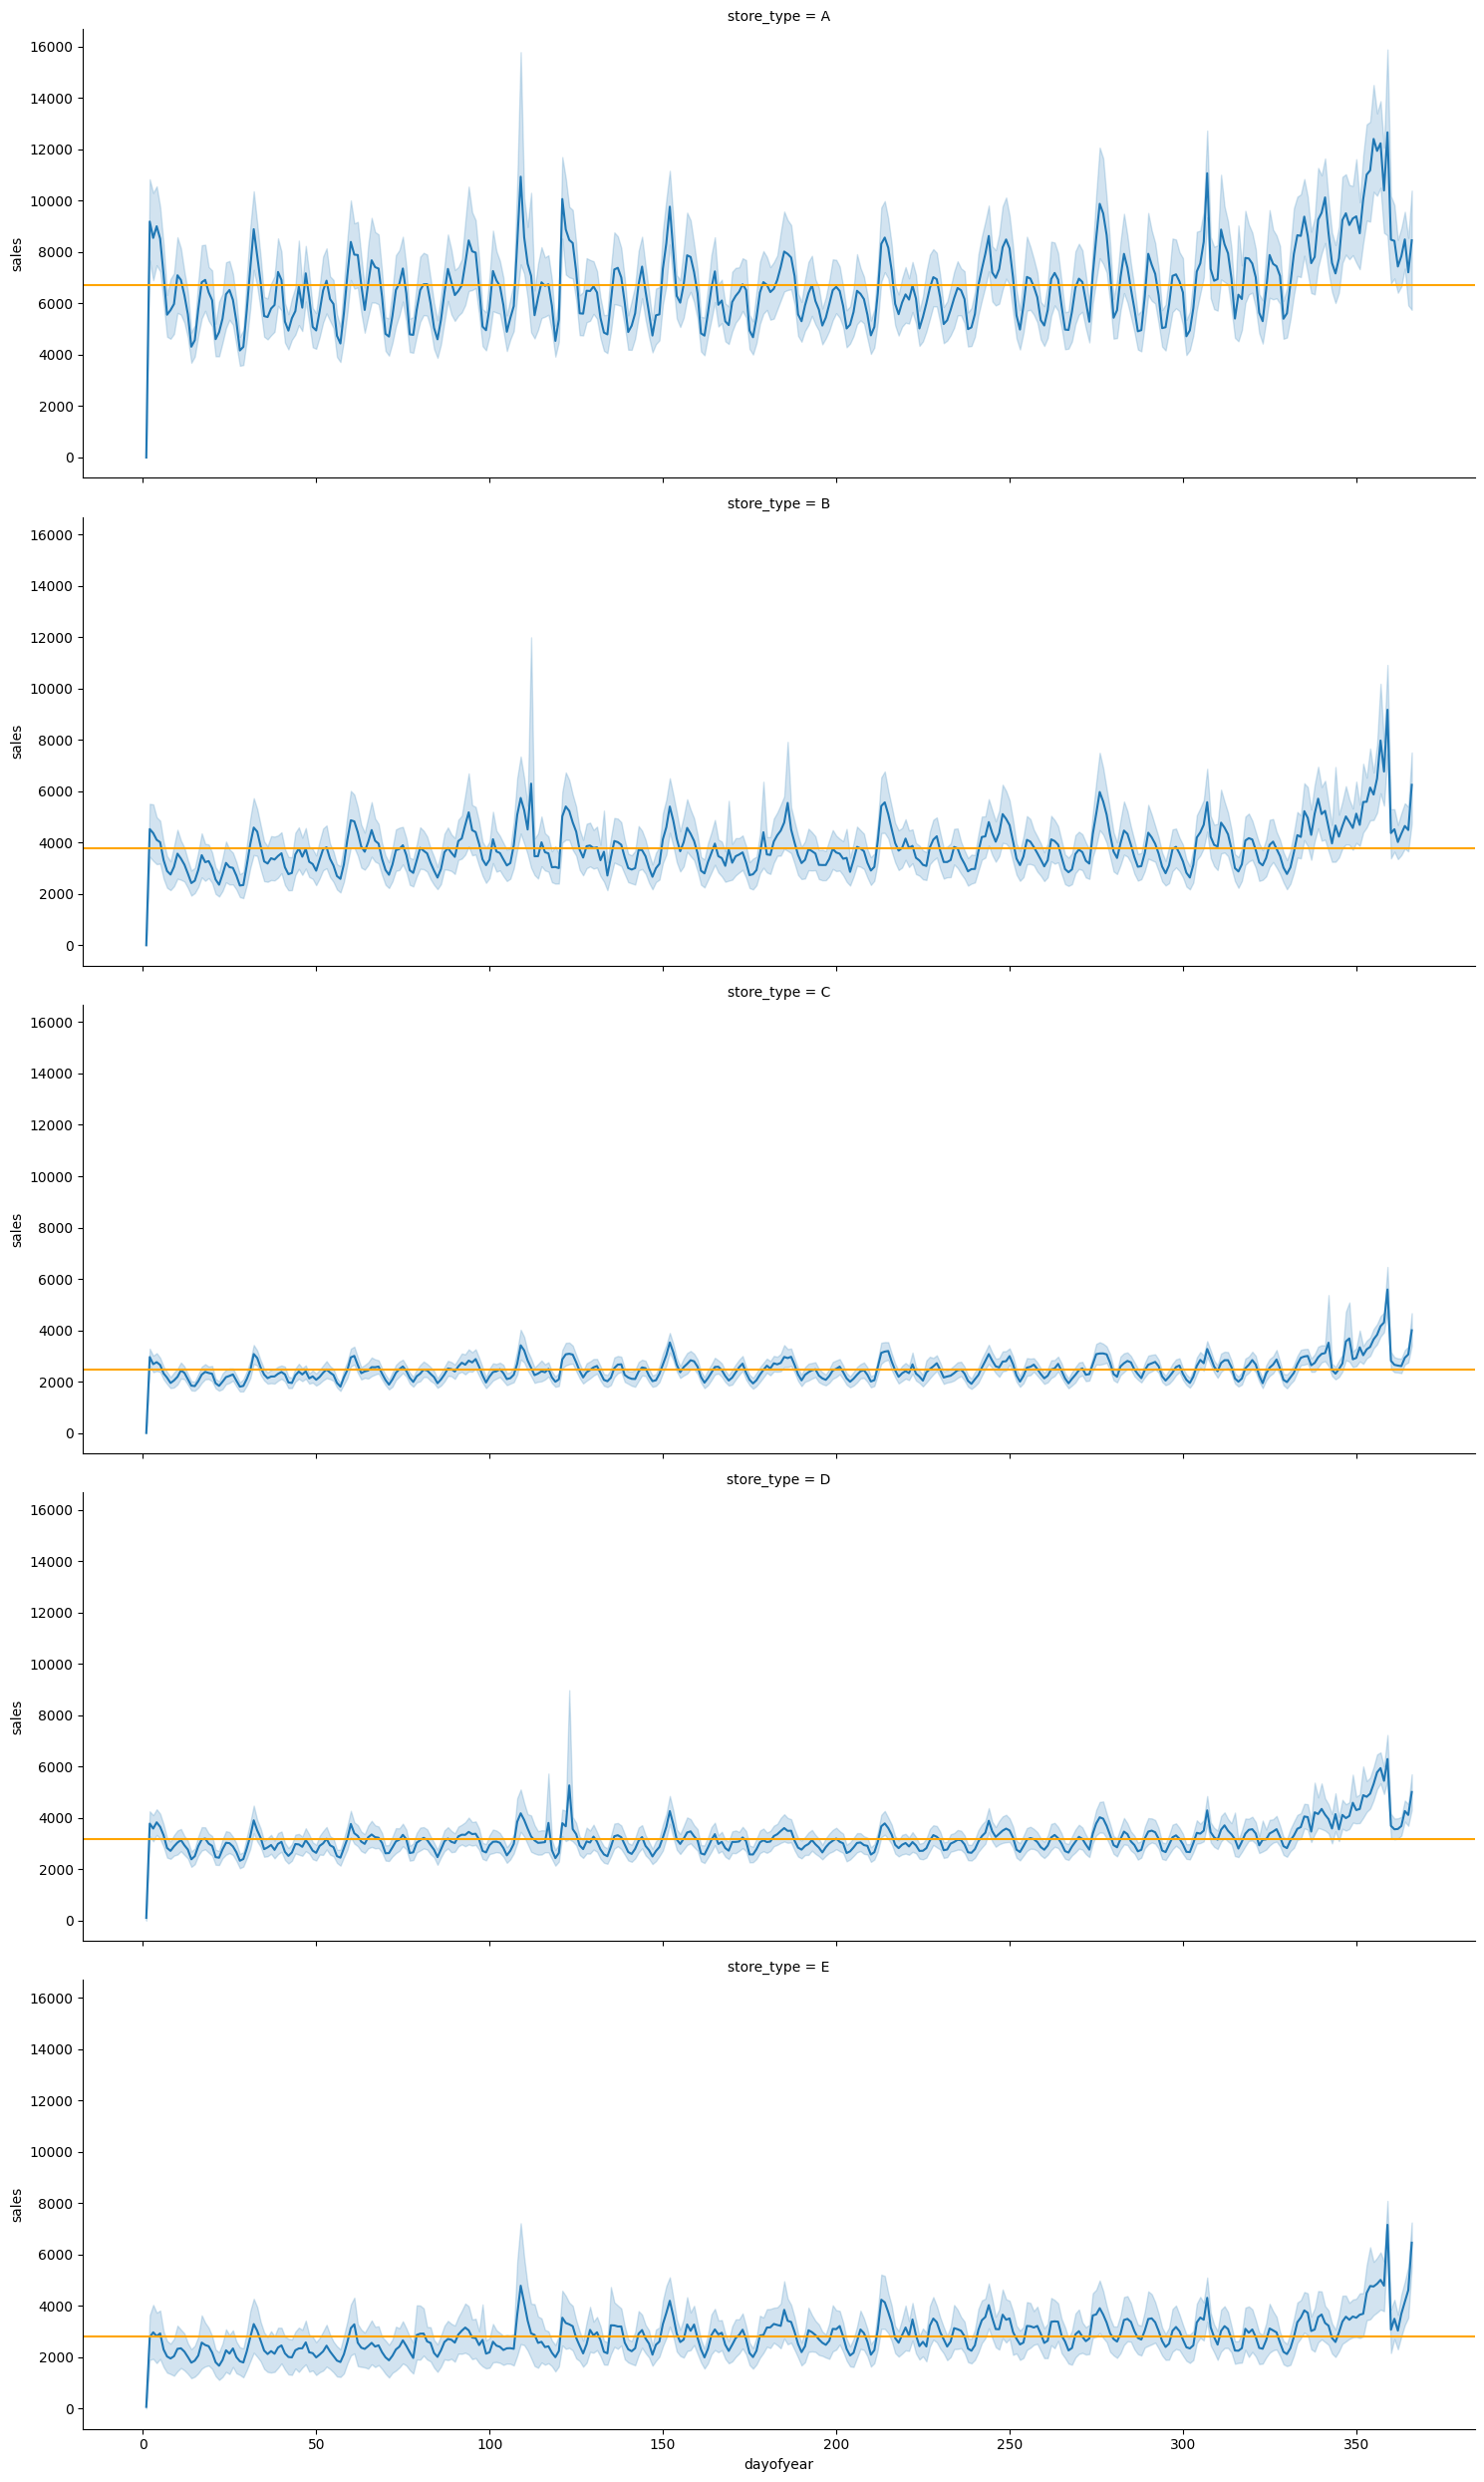

In [3]:
d = train.query("family== 'GROCERY I'") ## Focus on GROCERY I
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type') ## Use groupby as an function object
m = g[target].mean() ## Easier to get means

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE') ## Graph timeseries by store_type
                , kind='line', aspect=3)

## Since I have relplot as an FacetGrid, I can get the axes
## individually and map mean as an axhline for each
## store_type.
for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

## The goal is to be comfortable at looking for a category
## that fits the target. And see if it is worth adding
## into the model.

# > Low volume low volatility items
I need to figure out how to add zeros and ones to items that are insignificant like Books. The model is predicting variability that are applicable to the high volume items like groceries but in reality books are 1s and 0s. How?

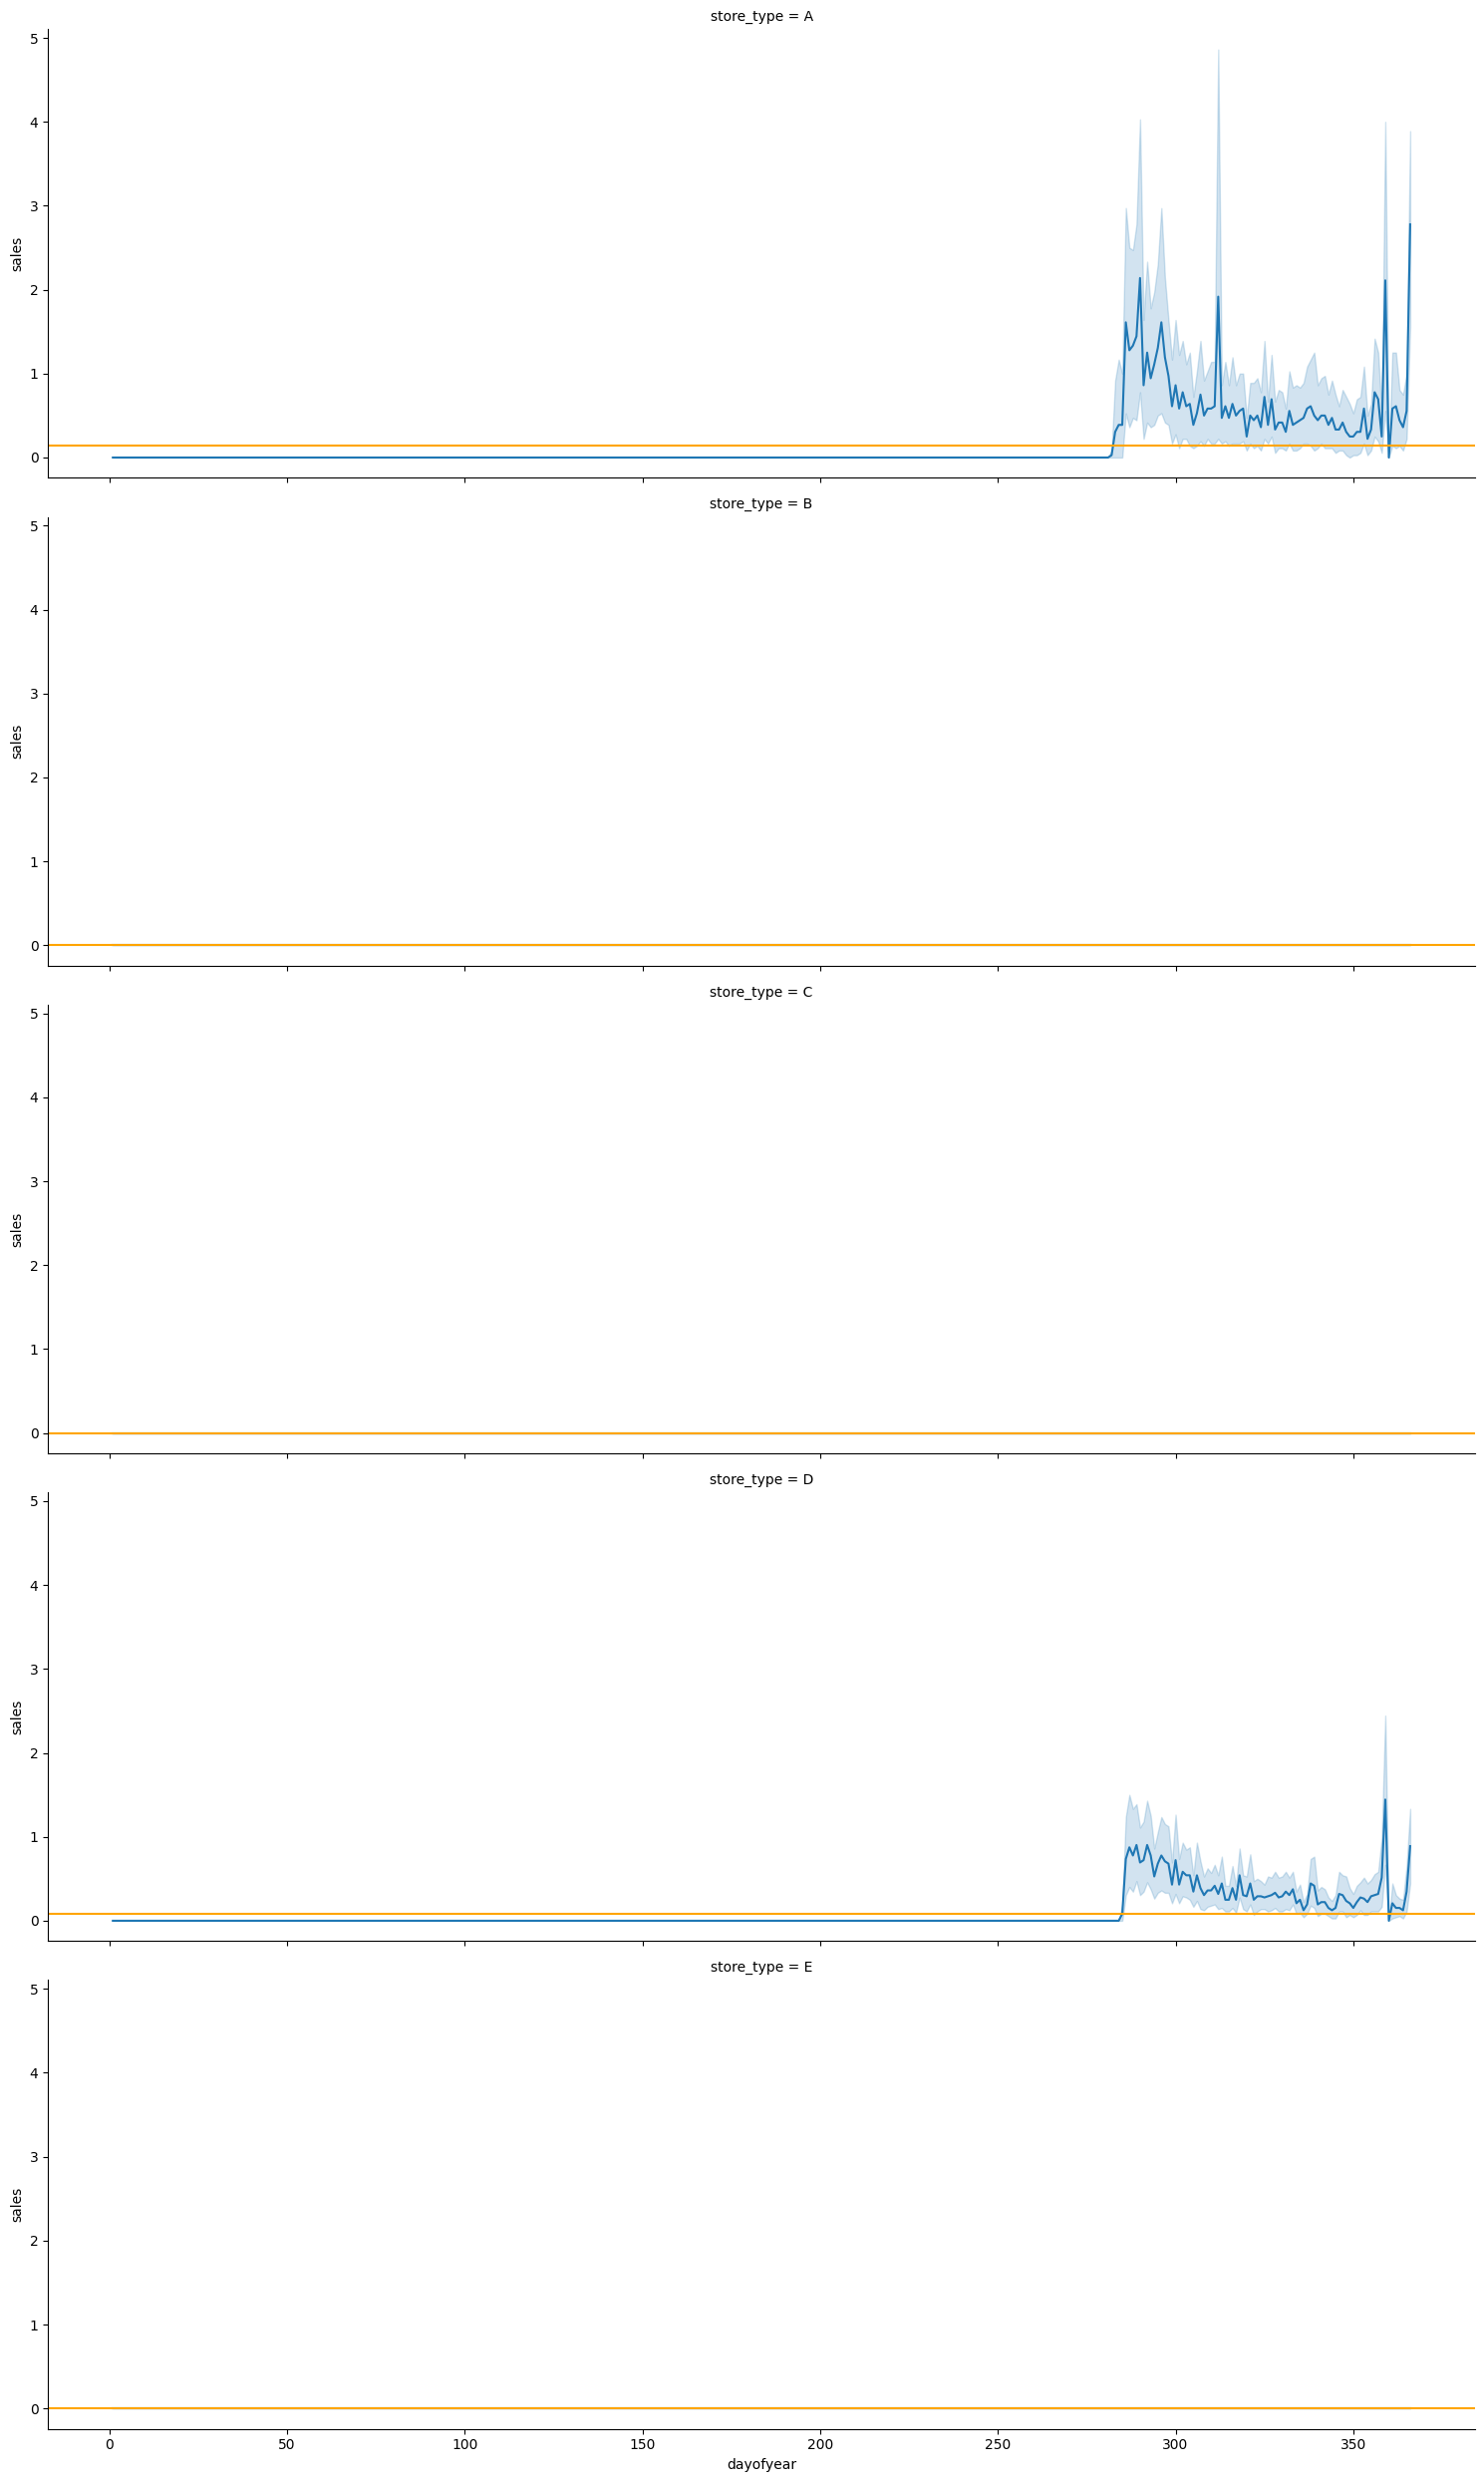

In [4]:
d = train.query("family== 'BOOKS'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

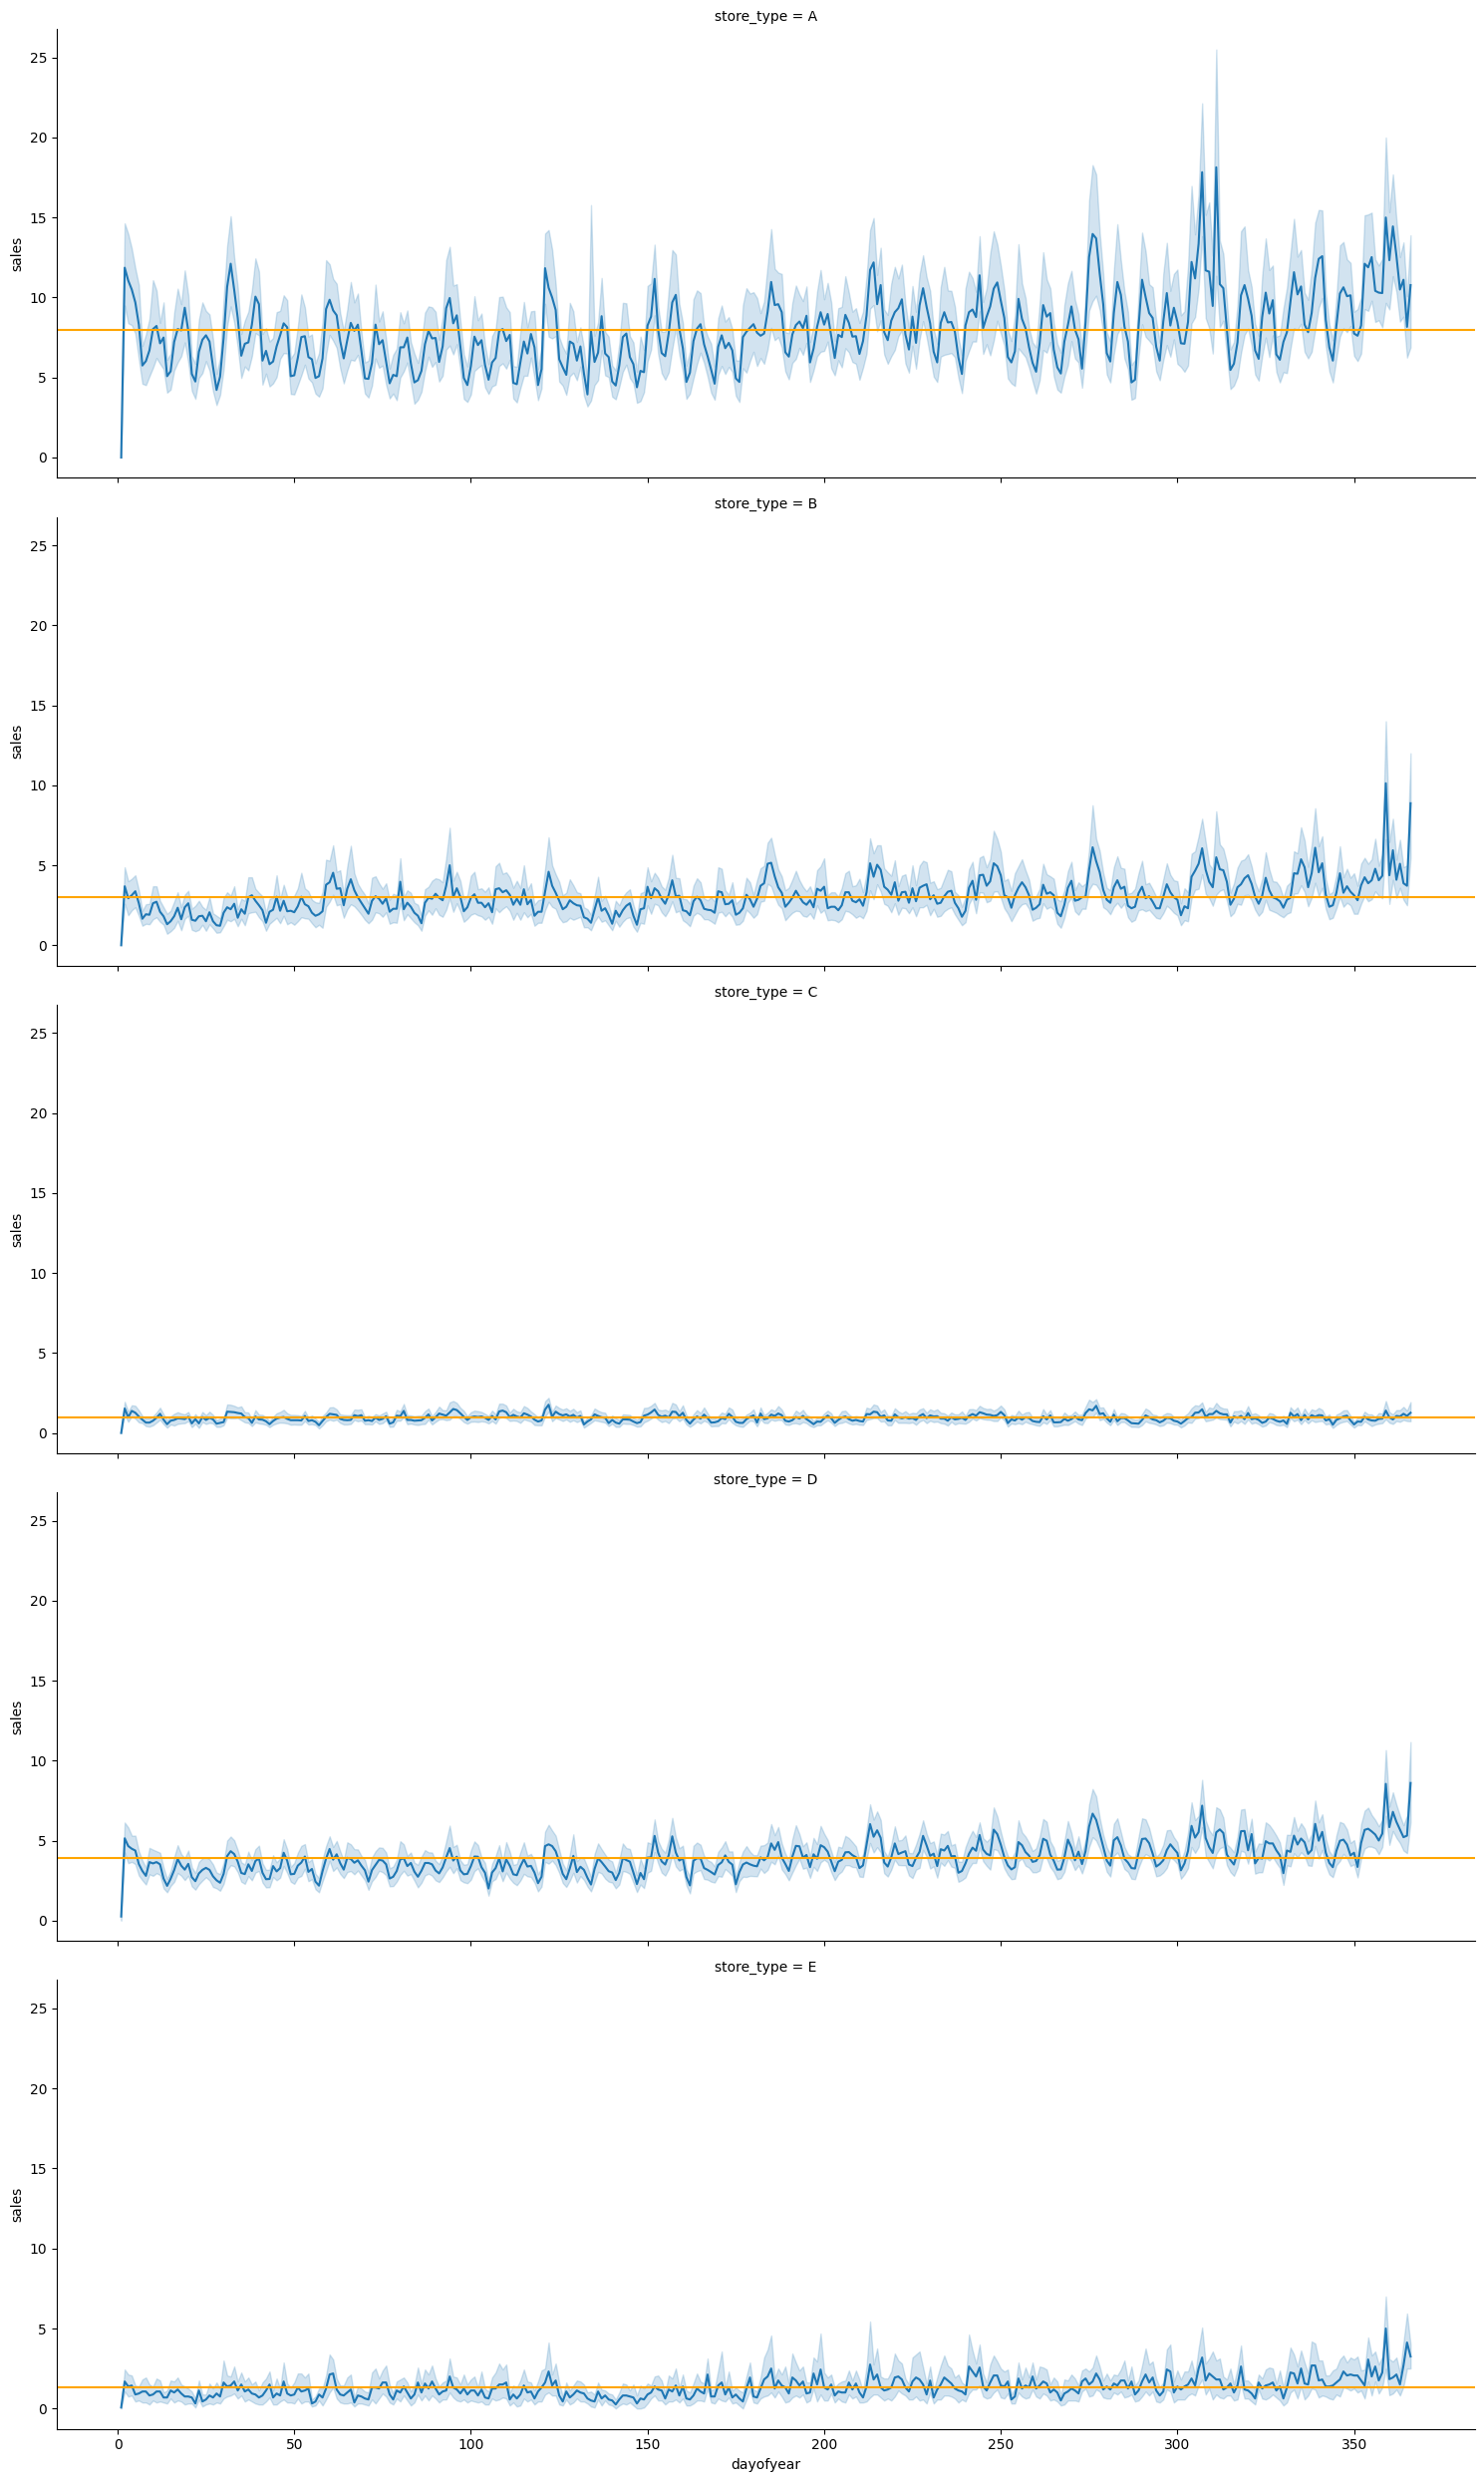

In [5]:
d = train.query("family== 'BEAUTY'")
d['store_type'] = d['store_nbr'].map(store_type)
g = d.groupby('store_type')
m = g[target].mean()

h = sns.relplot(d, x='dayofyear', y=target
                , row='store_type', row_order=list('ABCDE')
                , kind='line', aspect=3)

for ax, mean in zip(h.axes.flat, m):
    ax.axhline(y=mean, color='orange')

plt.show()

# > Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [6]:
g = train.query('store_type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )

,sum,std
family,,
GROCERY I,8.795437e+07,4002.821565
BEVERAGES,5.735129e+07,3320.277867
PRODUCE,3.531288e+07,3546.392141
CLEANING,2.368491e+07,987.190292
DAIRY,1.913834e+07,922.703547
POULTRY,1.104872e+07,562.829831
BREAD/BAKERY,1.064485e+07,480.295143
MEATS,1.041856e+07,443.761820
PERSONAL CARE,6.373462e+06,338.781103


# 🤖Model

# > Pipes

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att, storetype):
        self.att = att
        self.storetype = storetype
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = cleanData(X, self.storetype) ## Find this at Top.
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion', 'weeknum'], store_type))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['weekname', 'month'], store_type))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
# train_pp = pipe.transform(train)
# test_pp = pipe.transform(test)

FeatureUnion(transformer_list=[('numeric',
                                Pipeline(steps=[('dataselect',
                                                 DataSelect(att=['onpromotion',
                                                                 'weeknum'],
                                                            storetype={1: 'D',
                                                                       2: 'D',
                                                                       3: 'D',
                                                                       4: 'D',
                                                                       5: 'D',
                                                                       6: 'D',
                                                                       7: 'D',
                                                                       8: 'D',
                                                                       9: 'B',
                                                                       10: 'C',
                                                                       11: 'B',
                                                                       12: 'C',
                                                                       13: 'C',
                                                                       14: 'C',
                                                                       15: 'C',
                                                                       16: 'C',
                                                                       17: 'C',
                                                                       18: 'B',
                                                                       19: 'C',
                                                                       20: 'B',
                                                                       21: 'B',
                                                                       22: 'C',
                                                                       23: 'D',
                                                                       24: 'D',
                                                                       25: 'D',
                                                                       26: 'D',
                                                                       27: 'D',
                                                                       28: 'E',
                                                                       29: 'E',
                                                                       30: 'C', ...})),
                                                ('impute', SimpleIm...
                                Pipeline(steps=[('dataselect',
                                                 DataSelect(att=['weekname',
                                                                 'month'],
                                                            storetype={1: 'D',
                                                                       2: 'D',
                                                                       3: 'D',
                                                                       4: 'D',
                                                                       5: 'D',
                                                                       6: 'D',
                                                                       7: 'D',
                                                                       8: 'D',
                                                                       9: 'B',
                                                                       10: 'C',
                                                                       11: 'B',
                                                                       12: 'C',
                                                                       13: 'C',
                     

# > Baseline

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
def trainModels(d):
    ms = {}
    for member in d['family'].unique():
        for st in d['store_type'].unique():
            trn = d.loc[(d['family'] == member) & 
                        (d['store_type'] == st)]
            x_val = pipe.transform(trn)
            y_val = trn[target]
            model = LinearRegression()
            model.fit(x_val, y_val)
            ms[member + "|" + st] = model
        
    return ms

models = trainModels(train)

In [10]:
def makePredictions(d, mod):
    pr = []
    for member in d['family'].unique():
        for st in d['store_type'].unique():
            mem = member + "|" + st
            trn = d.loc[(d['family'] == member) & (d['store_type'] == st)]
            x_val = pipe.transform(trn)
            pr.append(pd.Series(mod[mem].predict(x_val), index=trn.index))
    return pd.concat(pr)

# > Do I train first or get?

In [11]:
g = train.copy()
g = g.query('family == "GROCERY I"')
gettrain = makePredictions(g, models)
gettrain

12          2498.029317
375         2498.029317
507         2498.029317
540         2498.029317
573         2498.029317
               ...     
2595990    15666.481098
2596023    15538.316032
2596089    15025.655768
2596122    14512.995504
2596155     9343.671176
Length: 78678, dtype: float64

In [12]:
g = train.copy()
g['preds'] = makePredictions(g, models)
g = g.query('family == "GROCERY I"')
trainget = g[['preds', target, 'date']]
trainget

,preds,sales,date
12,2498.029317,0.000,2013-01-01
45,2074.188731,0.000,2013-01-01
78,2774.055766,0.000,2013-01-01
111,2074.188731,0.000,2013-01-01
144,2074.188731,0.000,2013-01-01
...,...,...,...
2596221,4293.978075,5350.000,2016-12-31
2596254,6124.116143,7280.000,2016-12-31
2596287,5829.279462,3410.000,2016-12-31
2596320,5715.880739,5317.000,2016-12-31


In [13]:
gettrain.loc[12]

2498.0293173430628

In [14]:
trainget.loc[12]

preds            2498.029317
sales                    0.0
date     2013-01-01 00:00:00
Name: 12, dtype: object

In [15]:
gettrain.sort_index()

12         2498.029317
45         2074.188731
78         2774.055766
111        2074.188731
144        2074.188731
              ...     
2596221    4293.978075
2596254    6124.116143
2596287    5829.279462
2596320    5715.880739
2596353    8830.308953
Length: 78678, dtype: float64

In [16]:
trainget.sort_index()

,preds,sales,date
12,2498.029317,0.000,2013-01-01
45,2074.188731,0.000,2013-01-01
78,2774.055766,0.000,2013-01-01
111,2074.188731,0.000,2013-01-01
144,2074.188731,0.000,2013-01-01
...,...,...,...
2596221,4293.978075,5350.000,2016-12-31
2596254,6124.116143,7280.000,2016-12-31
2596287,5829.279462,3410.000,2016-12-31
2596320,5715.880739,5317.000,2016-12-31


# > Residuals. Make orange closer to blue dots.

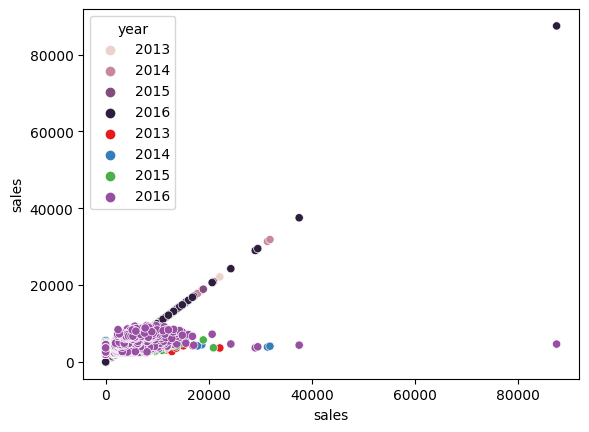

In [17]:
g = train.query('family == "GROCERY I"').copy()
g = g.query('store_type == "B"')
g
sns.scatterplot(g, x=target, y=target, hue='year');
sns.scatterplot(g, x=target, y=makePredictions(g, models), hue='year', palette='Set1');
# sns.scatterplot(x=g[target],y=makePredictions(g, models), hue='year');
## improve this. you are in the right direction.

# > Predicted Demand vs Actual Sales
Why are the predictions lower than actual? I think it is because the predictions accounts for all types of stores. The lower volume stores are dragging the average down.

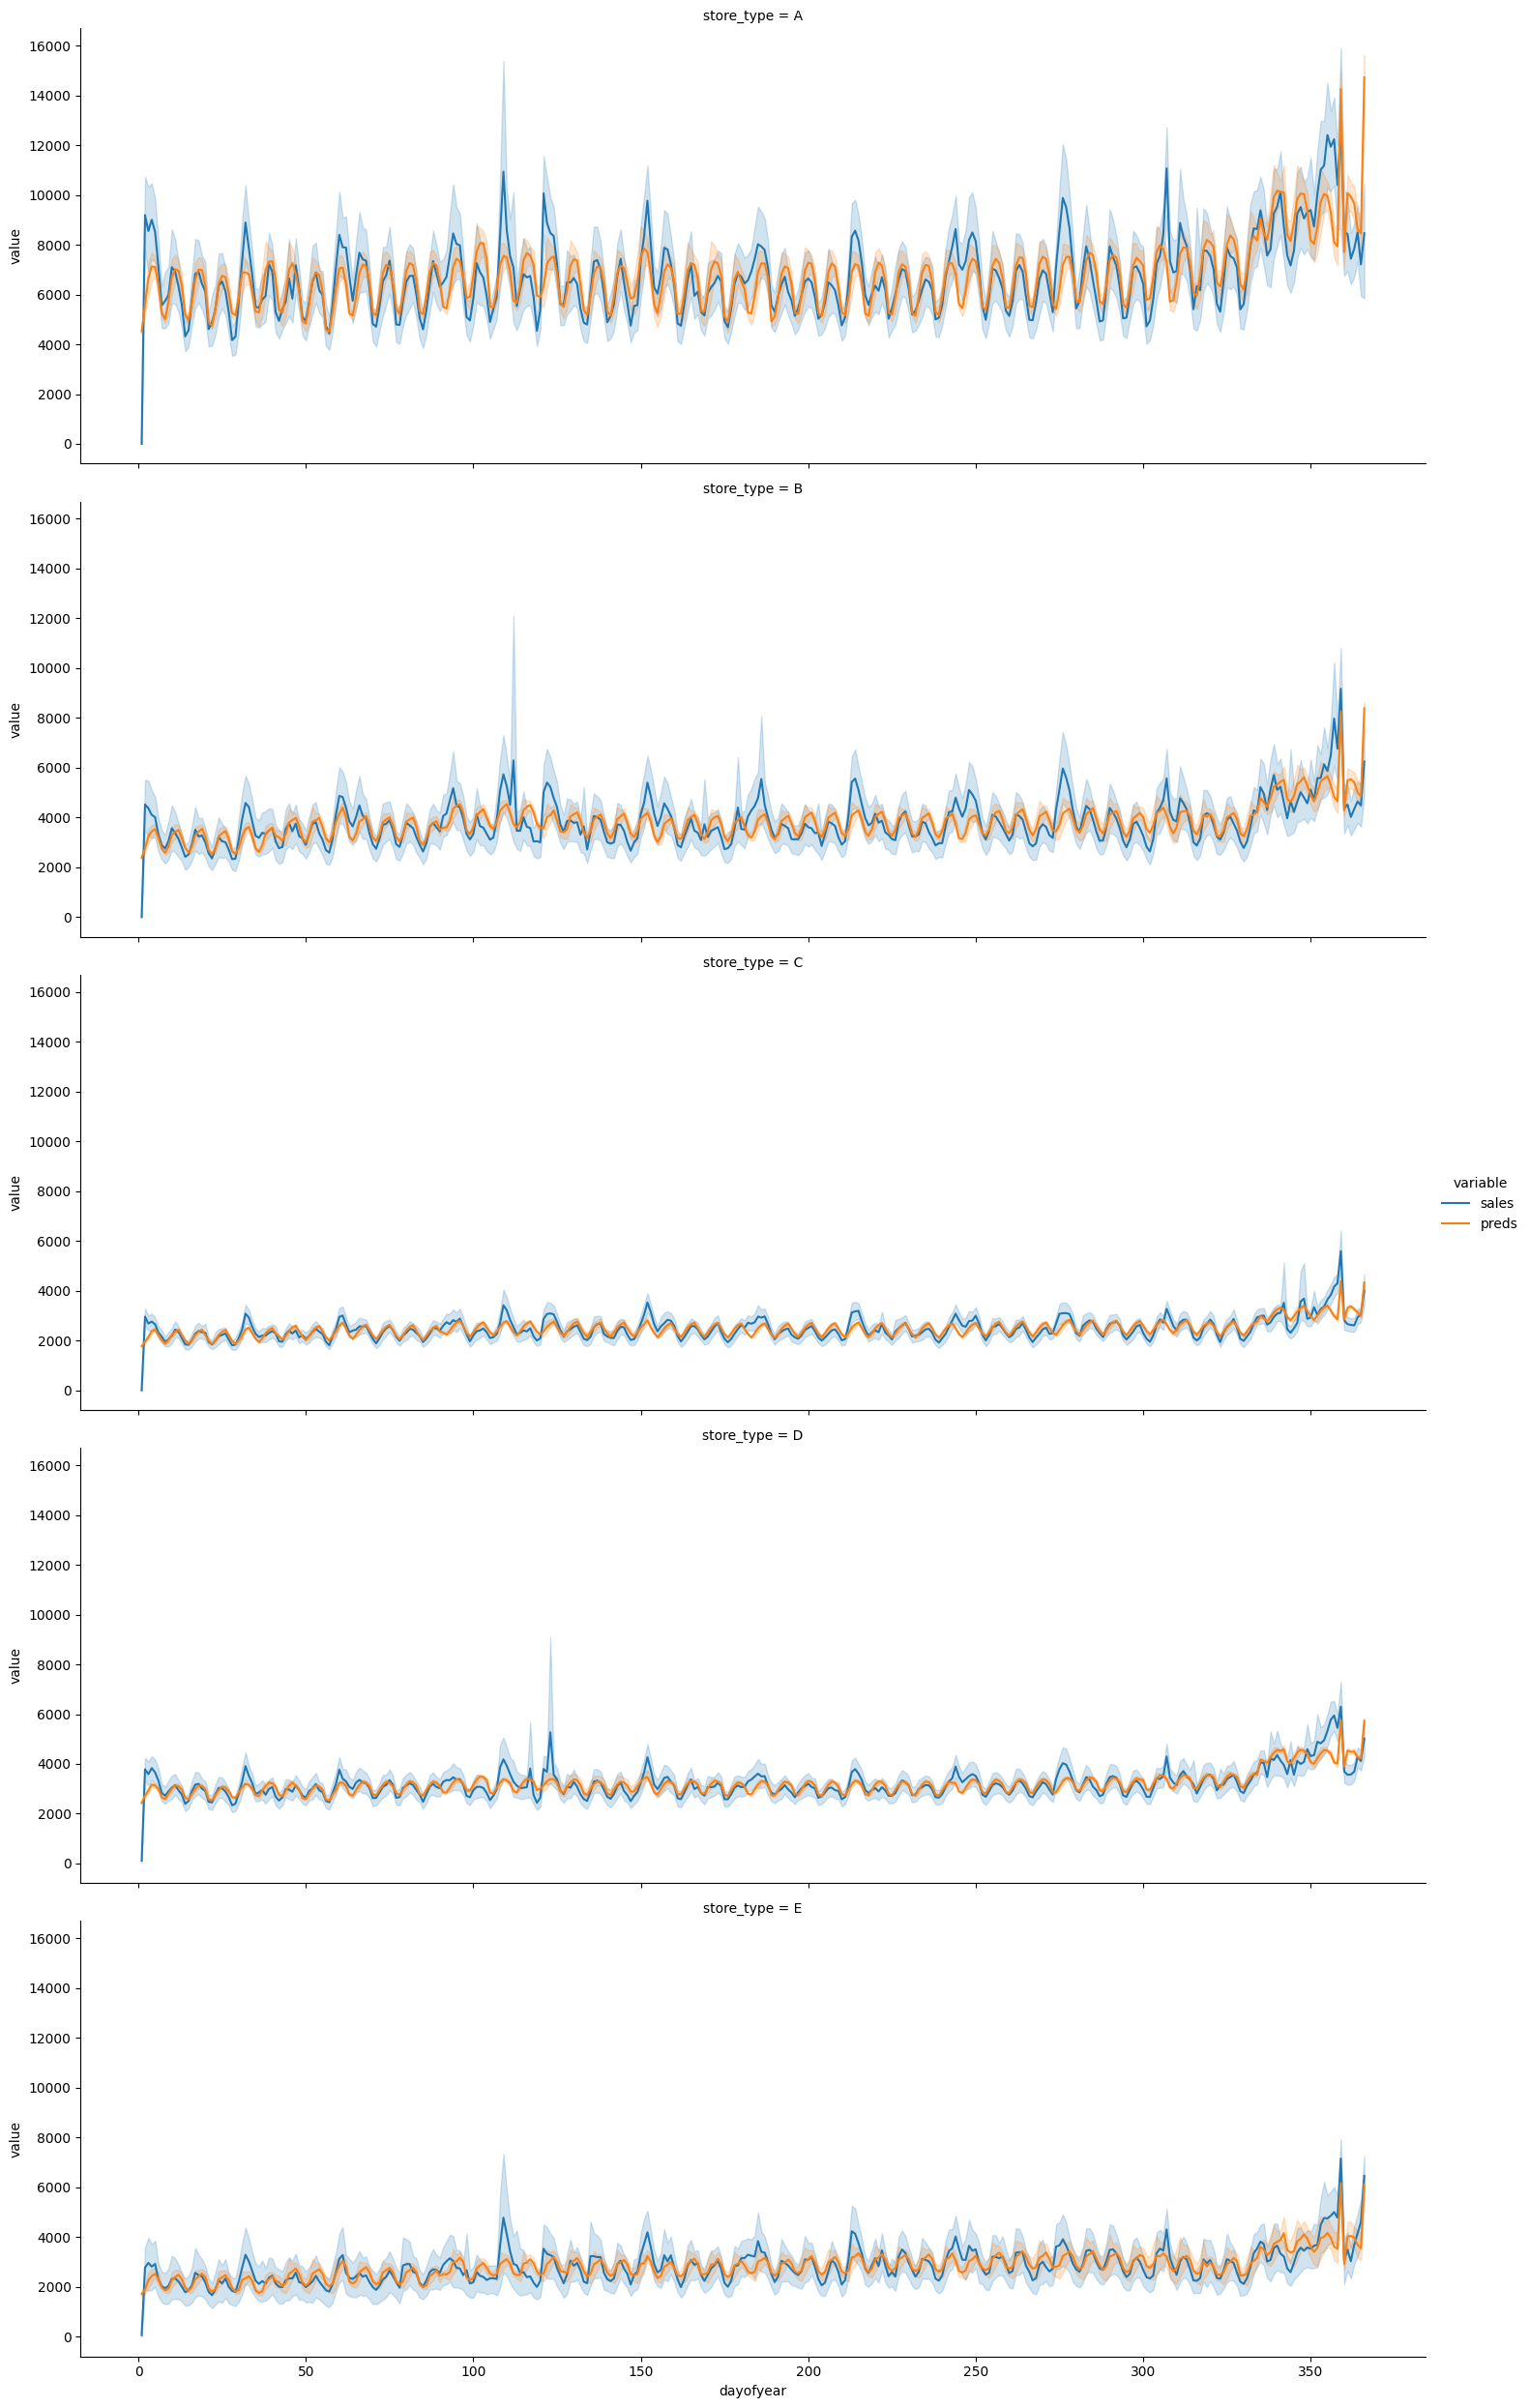

In [18]:
g = train.copy()
g = g.query('family == "GROCERY I"')
g['preds'] = makePredictions(g, models)

g = g[['store_type', 'sales', 'preds', 'dayofyear']]
g = pd.melt(g, id_vars=['store_type', 'dayofyear'])

sns.relplot(g, x='dayofyear', y='value', hue='variable'
            , row='store_type'
            , row_order=list('ABCDE')
            , kind='line', aspect=3);

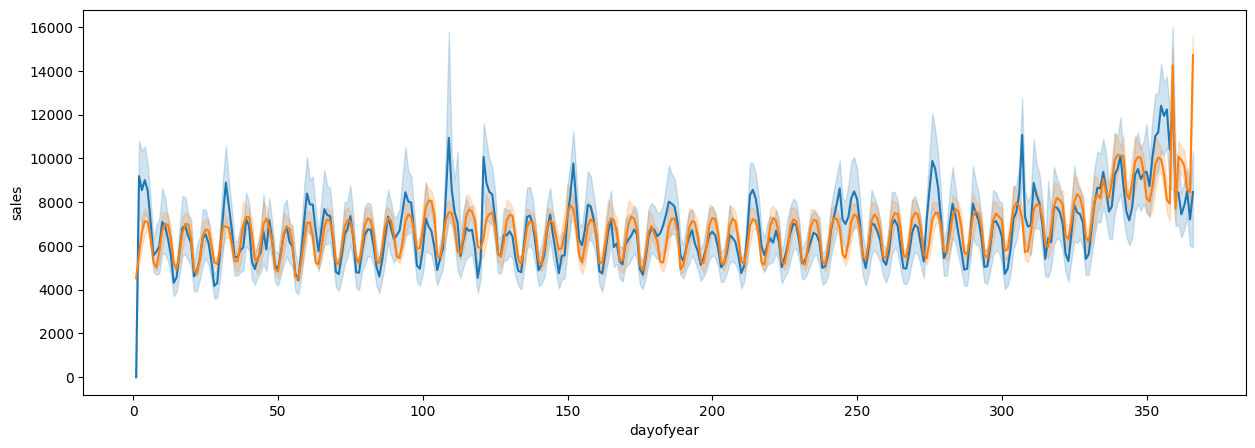

In [19]:
g = train.query('family == "GROCERY I"')
g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
g_pp = pipe.transform(g)
g_model = LinearRegression()
g_model.fit(g_pp, g[target])
g['preds'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax);
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax);

# > Questioning the zeros
Do I train the model without the zeros? Do I train each family and cluster separately?
Yes, you need to train the model for each family. And the zeros matter.

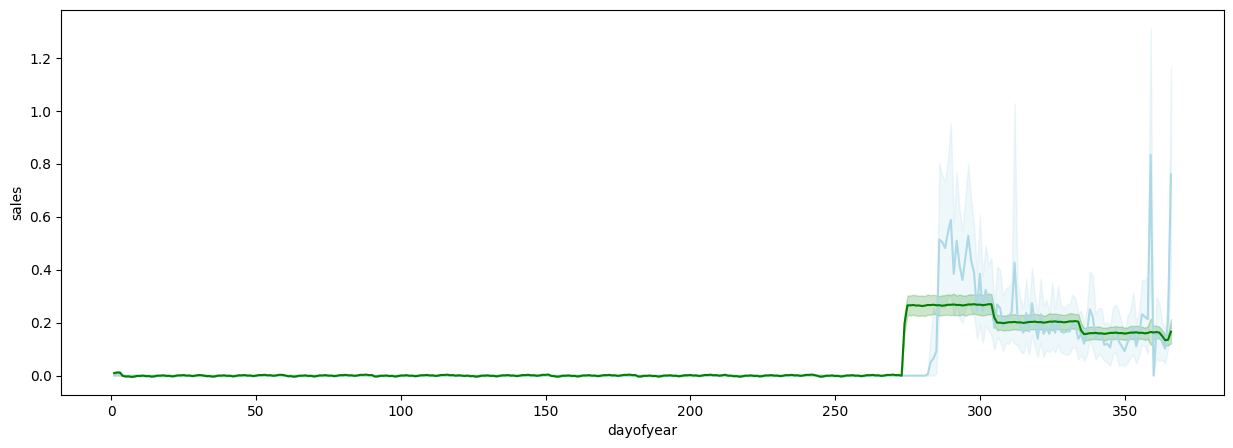

In [20]:
g = train.copy()
g = g.query('family == "BOOKS"')
g['preds'] = makePredictions(g, models)
# g = g.query('store_type == "A"')
# g = g.loc[g[target] != 0]
# g_pp = pipe.transform(g)
# g_model = LinearRegression()
# g_model.fit(g_pp, g[target])
# g['preds_nonzero'] = g_model.predict(g_pp)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
# sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='orange');
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='green');

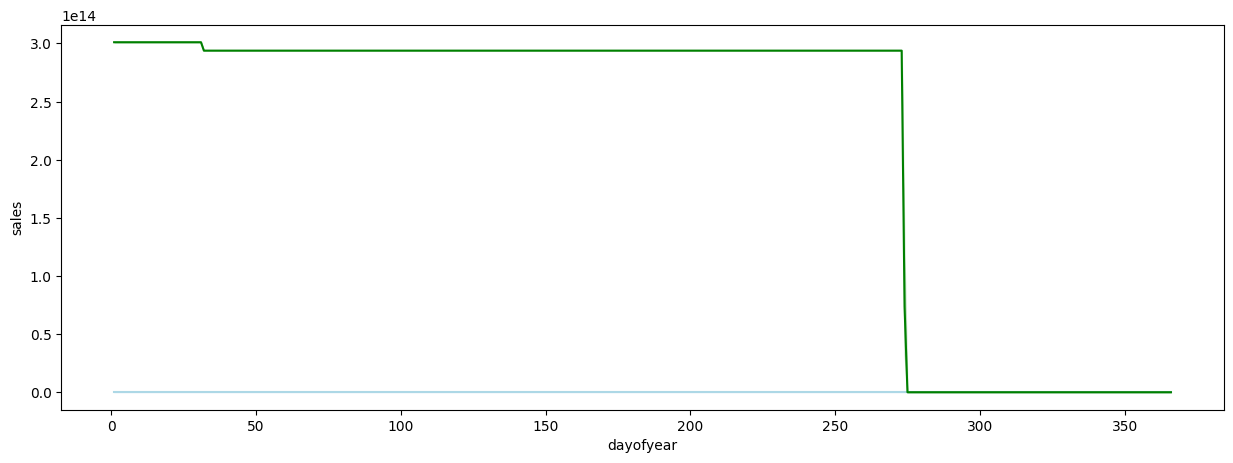

In [21]:
g = train.copy()
g = g.query('family == "BOOKS"')
g = g.query('store_type == "A"')

g_tr = g.loc[g[target] != 0]
g_model = LinearRegression()
g_model.fit(pipe.transform(g_tr), g_tr[target])
g['preds'] = g_model.predict(pipe.transform(g))

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=g, x='dayofyear', y=target, ax=ax, color='lightblue');
sns.lineplot(data=g, x='dayofyear', y='preds', ax=ax, color='green');

# > Submission

In [22]:
# train['preds'] = makePredictions(train, models)
# %load_ext autoreload
# %autoreload 2
# import datawarehouse as dw
# dw.uploadData(train, "store_sales_v03")

In [23]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
samp['store_type'] = samp['store_nbr'].map(store_type)
pd.DataFrame({
    'id': samp['id']
    , 'sales': makePredictions(samp, models)
}).to_csv('submission.csv', index=False)